# FB Prohpet Modelling 

In [12]:
#import Prophet
!pip install prophet

import prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
#import pandas, numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

#import root mean squared error from statsmodels
from statsmodels.tools.eval_measures import rmse

In [14]:
#import iterative imputer
!pip install fancyimpute -q
from fancyimpute import IterativeImputer

## Load in Data and Prepare for Modelling

In [15]:
apples = pd.read_csv('https://raw.githubusercontent.com/mckenzie-maidl/data5100-climate-agriculture/main/Cleaned%20Data/WA_apples_1889_2021.csv')
prism = pd.read_csv('https://raw.githubusercontent.com/mckenzie-maidl/data5100-climate-agriculture/main/Cleaned%20Data/prism.csv')

In [16]:
#clean and prepare weather data from prism
prism.drop(columns='Unnamed: 0', inplace=True)

#rename columns
cols = list(prism.columns)
new = ['ppt', 'tmin', 'tmean', 'tmax', 'tdewmean', 'vpdmin', 'vpdmax', 'county', 'year', 'month']
new_cols = dict(zip(cols,new))
prism.rename(columns=new_cols, inplace=True)

#add in vpddiff and temp diff and vpdmean
prism['vpddiff'] = prism['vpdmax'] - prism['vpdmin']
prism['tdiff'] = prism['tmax'] - prism['tmin']
prism['vpdmean'] = (prism['vpdmax'] + prism['vpdmin']) / 2

In [17]:
#clean and prep apple data
apples2 = apples.dropna().sort_values(by='year').set_index('year')
apples2.drop(columns='Unnamed: 0', inplace=True)

In [18]:
#copy prism for further cleaning
prism2 = prism.copy()

#groupby, mean for everything except precip and reset index
prism2 = prism.groupby('year').mean().drop(columns='month')
prism2['ppt'] = prism.groupby('year')['ppt'].sum()

#join with apples2
prism2 = prism2.loc[1919:].join(apples2['yield_acre_lbs'])
prism2.reset_index(inplace=True)

#make year into datetime and drop original year
prism2['date'] = prism2['year'].apply(str) + '-' + '01'
prism2['date'] = pd.to_datetime(prism2['date'])
prism2.drop(columns='year', inplace=True)

# Model

## Calculate Yield Per Tree

In [19]:
apple_farms = pd.read_csv('https://raw.githubusercontent.com/mckenzie-maidl/data5100-climate-agriculture/main/Cleaned%20Data/apples_1970.csv')

In [20]:
#drop unnamed and add yield per tree
apple_farms.drop(columns='Unnamed: 0', inplace=True)
#divide yield per acre by trees per acre to get yield per tree
apple_farms['yield_tree'] = apple_farms['yield_acre_lbs']/apple_farms['trees_per_acre']
#take past 50 years
apple_farms = apple_farms.sort_values(by='year').set_index('year').loc[1972:]

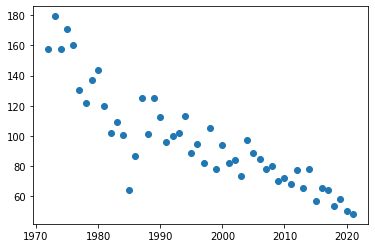

In [21]:
#plot yield per tree over time
plt.figure(0)

plt.scatter(apple_farms.index , apple_farms['yield_tree'])

In [22]:
#make copy of prism
prism3 = prism.copy()

#groupby, mean for everything except precipitation
prism3 = prism.groupby('year').mean().drop(columns='month')
prism3['ppt'] = prism.groupby('year')['ppt'].sum()

#join with yield tree from apple farms and reset index, taking last 50 years of data
prism3 = prism3.loc[1972:].join(apple_farms['yield_tree'])
prism3.reset_index(inplace=True)

#make year into datetime and drop original year
prism3['date'] = prism3['year'].apply(str) + '-' + '01'
prism3['date'] = pd.to_datetime(prism3['date'])
prism3.drop(columns='year', inplace=True)

In [23]:
prism3.head()

,ppt,tmin,tmean,tmax,tdewmean,vpdmin,vpdmax,vpddiff,tdiff,vpdmean,yield_tree,date
0,160.07,35.936667,47.560000,59.190833,31.820000,1.539500,14.790417,13.250917,23.254167,8.164958,157.833656,1972-01-01
1,151.75,37.214167,48.848333,60.475833,31.831667,2.014167,15.471333,13.457167,23.261667,8.742750,179.322328,1973-01-01
2,143.71,37.306667,48.983333,60.665000,32.799167,1.925167,15.160417,13.235250,23.358333,8.542792,157.728707,1974-01-01
3,176.08,36.076667,47.360000,58.643333,32.312500,1.686667,14.011333,12.324667,22.566667,7.849000,170.974729,1975-01-01
4,97.12,36.110833,47.941667,59.785833,32.952500,1.477500,13.763417,12.285917,23.675000,7.620458,160.319574,1976-01-01


In [24]:
prism3.tail()

,ppt,tmin,tmean,tmax,tdewmean,vpdmin,vpdmax,vpddiff,tdiff,vpdmean,yield_tree,date
45,175.55,37.214167,47.962500,58.707500,32.510000,1.788917,14.796583,13.007667,21.493333,8.292750,64.447592,2017-01-01
46,135.34,38.705833,49.804167,60.909167,33.755833,1.734167,15.032417,13.298250,22.203333,8.383292,54.004885,2018-01-01
47,126.79,37.000000,47.501667,58.002500,33.609167,1.395917,13.315250,11.919333,21.002500,7.355583,58.406612,2019-01-01
48,137.08,38.450833,49.898333,61.340833,34.004167,1.877250,15.286333,13.409083,22.890000,8.581792,50.384990,2020-01-01
49,130.38,39.106667,50.352500,61.603333,34.324167,2.285833,16.425000,14.139167,22.496667,9.355417,48.448917,2021-01-01


In [25]:
prism3.shape

(50, 12)

## Model with yield per tree

In [26]:
#make a df p with datetime and yield_tree
p = prism3[['date', 'yield_tree']]
p.rename(columns={'date':'ds', 'yield_tree': 'y'}, inplace=True)

#add potential predictors
best_predictors = list(prism3.columns[:10])
for predictor in best_predictors:
  p[predictor] = prism3[predictor]
p.apply(lambda x: x.isna().sum())

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-26-8e8f46e709ee>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[predictor] = prism3[predictor]


ds          0
y           0
ppt         0
tmin        0
tmean       0
tmax        0
tdewmean    0
vpdmin      0
vpdmax      0
vpddiff     0
tdiff       0
vpdmean     0
dtype: int64

In [27]:
p.shape

(50, 12)

In [28]:
#split into train and test, last ten years is test
train = p[:-10]
test = p[-10:]

In [29]:
train.tail()

,ds,y,ppt,tmin,tmean,tmax,tdewmean,vpdmin,vpdmax,vpddiff,tdiff,vpdmean
35,2007-01-01,78.341014,122.61,37.030000,48.349167,59.674167,33.490833,1.436417,14.037000,12.600583,22.644167,7.736708
36,2008-01-01,80.287206,110.83,35.610833,47.200833,58.787500,31.599167,1.542500,13.993333,12.450833,23.176667,7.767917
37,2009-01-01,70.074196,128.39,36.566667,47.811667,59.065833,31.585833,1.701417,14.686083,12.984667,22.499167,8.193750
38,2010-01-01,72.435395,183.97,38.096667,48.667500,59.233333,34.784167,1.265667,12.738750,11.473083,21.136667,7.002208
39,2011-01-01,68.232662,139.44,36.036667,47.154167,58.275833,31.601667,1.605750,13.229333,11.623583,22.239167,7.417542


In [30]:
print(train.shape)
print(test.shape)

(40, 12)
(10, 12)


In [31]:
#train the model on the historical data, adding in regressors
m = Prophet()
for reg in ['tdiff', 'vpdmin', 'ppt', 'vpdmean', 'vpddiff']:
  m.add_regressor(reg)
m.fit(train)

#make past and future df for trained model and forecasted model
past = m.predict(train)
future = test
forecast = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr5xdj8nm/s4n3r9ni.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr5xdj8nm/_x68cj34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67063', 'data', 'file=/tmp/tmpr5xdj8nm/s4n3r9ni.json', 'init=/tmp/tmpr5xdj8nm/_x68cj34.json', 'output', 'file=/tmp/tmpr5xdj8nm/prophet_model78j6t5n5/prophet_model-20221207233751.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:37:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


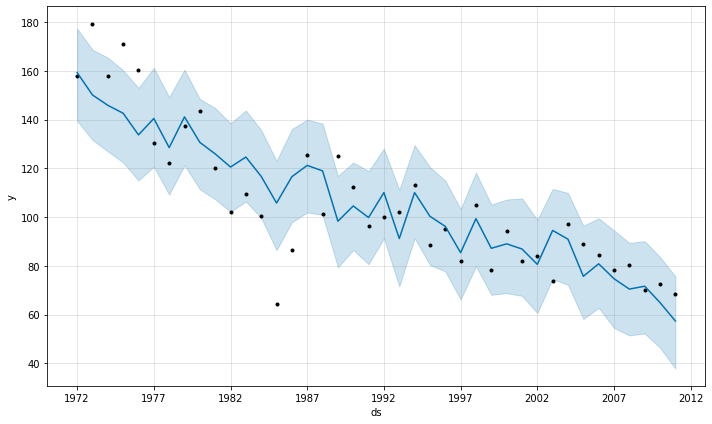

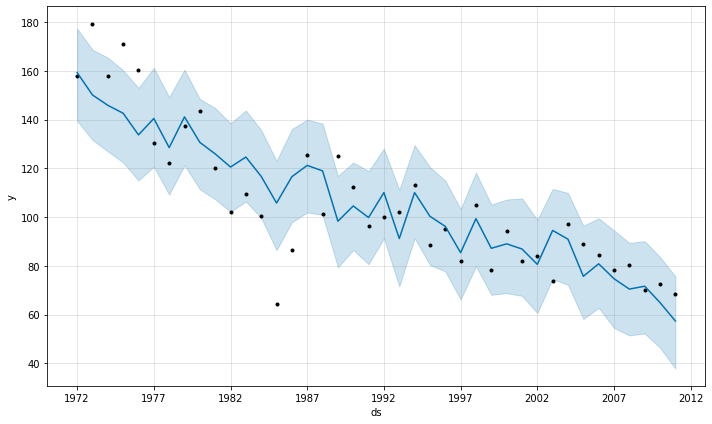

In [32]:
#plot fitted model
m.plot(past)

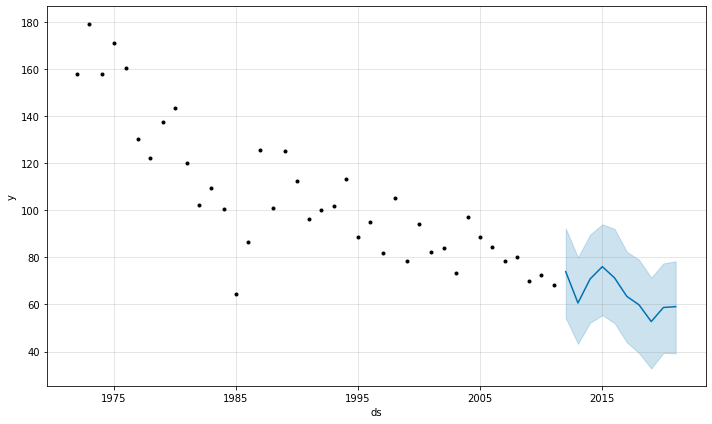

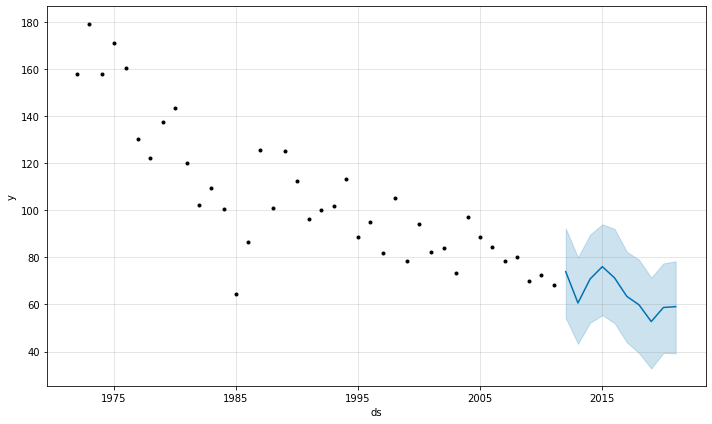

In [33]:
#plot forecast
m.plot(forecast)

In [34]:
forecast['yhat']

0    73.948913
1    60.644368
2    70.870217
3    76.070775
4    71.281039
5    63.432133
6    59.851510
7    52.741461
8    58.721375
9    59.084026
Name: yhat, dtype: float64

In [35]:
#Assessing Model Accuracy
#training model
predictions = past['yhat']
print('Traing RMSE: ', rmse(predictions, train['y']))
print('Average of Train Data: ', train['y'].mean())
print('Training RMSE/AVG: ', rmse(predictions, train['y'])/train['y'].mean())

print('')
print('*' * 30)
print('')

#testing model
predictions = forecast['yhat']
print('Testing RMSE: ', rmse(predictions, test['y']))
print('Average of Test Data: ', test['y'].mean())
print('Testing RMSE/AVG: ', rmse(predictions, test['y'])/test['y'].mean())

Traing RMSE:  14.949012657844786
Average of Train Data:  106.04393561074153
Training RMSE/AVG:  0.14096999108669966

******************************

Testing RMSE:  8.62184716218035
Average of Test Data:  61.904229566292756
Testing RMSE/AVG:  0.13927719030809166


In [36]:
#compare the results with parameters to the results without parameters
m_no_reg = Prophet()
m_no_reg.fit(train[['ds', 'y']])

#make future and past dfs
past_no_reg = m_no_reg.predict(train[['ds', 'y']])
future_no_reg = test[['ds', 'y']]
forecast_no_reg = m_no_reg.predict(future_no_reg)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr5xdj8nm/b3z3os1e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr5xdj8nm/7wdgiy1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5672', 'data', 'file=/tmp/tmpr5xdj8nm/b3z3os1e.json', 'init=/tmp/tmpr5xdj8nm/7wdgiy1_.json', 'output', 'file=/tmp/tmpr5xdj8nm/prophet_modelgwdjyow2/prophet_model-20221207233753.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:37:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:37:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
#training model with no parameters
#accuracy of the training model
predictions = past_no_reg['yhat']
print('Traing RMSE: ', rmse(predictions, train['y']))
print('Average of Train Data: ', train['y'].mean())
print('Training RMSE/AVG: ', rmse(predictions, train['y'])/train['y'].mean())

print('')
print('*' * 30)
print('')

#testing model with no parameters
predictions = forecast_no_reg['yhat']
print('Testing RMSE: ', rmse(predictions, test['y']))
print('Average of Test Data: ', test['y'].mean())
print('Testing RMSE/AVG: ', rmse(predictions, test['y'])/test['y'].mean())

Traing RMSE:  16.196970046702354
Average of Train Data:  106.04393561074153
Training RMSE/AVG:  0.15273829619222196

******************************

Testing RMSE:  10.583879001883977
Average of Test Data:  61.904229566292756
Testing RMSE/AVG:  0.17097182334770492


Adding in the regressors makes the model better, but not a whole lot.

# Forecasting 5 Years Out

## Imputing with MICE

In [38]:
#add some empty rows to the df for next five years
empty = pd.DataFrame({'ppt':[np.nan,np.nan,np.nan,np.nan,np.nan], 'tmin':[np.nan,np.nan,np.nan,np.nan,np.nan], 'tmean':[np.nan,np.nan,np.nan,np.nan,np.nan], 'tmax':[np.nan,np.nan,np.nan,np.nan,np.nan], 'tdewmean':[np.nan,np.nan,np.nan,np.nan,np.nan],
                     'vpdmin':[np.nan,np.nan,np.nan,np.nan,np.nan], 'vpdmax':[np.nan,np.nan,np.nan,np.nan,np.nan], 'tdiff' :[np.nan,np.nan,np.nan,np.nan,np.nan], 'tdiff' :[np.nan,np.nan,np.nan,np.nan,np.nan], 
                     'yield_tree' :[np.nan,np.nan,np.nan,np.nan,np.nan], 'date': ['2022-01', '2023-01', '2024-01', '2025-01', '2026-01']})

prism3_future = prism3.append(empty)

prism3_future['date'] = pd.to_datetime(prism3_future['date'])

In [39]:
#mice imputation
X = prism3_future[prism3_future.columns[0:10]]
imputer = IterativeImputer()
prism3_future[prism3_future.columns[0:10]] = imputer.fit_transform(X)

prism2_future = prism3_future.reset_index(drop=True)

In [40]:
prism3_future.head()

,ppt,tmin,tmean,tmax,tdewmean,vpdmin,vpdmax,vpddiff,tdiff,vpdmean,yield_tree,date
0,160.07,35.936667,47.560000,59.190833,31.820000,1.539500,14.790417,13.250917,23.254167,8.164958,157.833656,1972-01-01
1,151.75,37.214167,48.848333,60.475833,31.831667,2.014167,15.471333,13.457167,23.261667,8.742750,179.322328,1973-01-01
2,143.71,37.306667,48.983333,60.665000,32.799167,1.925167,15.160417,13.235250,23.358333,8.542792,157.728707,1974-01-01
3,176.08,36.076667,47.360000,58.643333,32.312500,1.686667,14.011333,12.324667,22.566667,7.849000,170.974729,1975-01-01
4,97.12,36.110833,47.941667,59.785833,32.952500,1.477500,13.763417,12.285917,23.675000,7.620458,160.319574,1976-01-01


In [41]:
prism3_future.tail()

,ppt,tmin,tmean,tmax,tdewmean,vpdmin,vpdmax,vpddiff,tdiff,vpdmean,yield_tree,date
0,145.493,37.31305,48.604317,59.8972,33.32065,1.612798,14.222528,12.60973,22.58415,7.917663,NaN,2022-01-01
1,145.493,37.31305,48.604317,59.8972,33.32065,1.612798,14.222528,12.60973,22.58415,7.917663,NaN,2023-01-01
2,145.493,37.31305,48.604317,59.8972,33.32065,1.612798,14.222528,12.60973,22.58415,7.917663,NaN,2024-01-01
3,145.493,37.31305,48.604317,59.8972,33.32065,1.612798,14.222528,12.60973,22.58415,7.917663,NaN,2025-01-01
4,145.493,37.31305,48.604317,59.8972,33.32065,1.612798,14.222528,12.60973,22.58415,7.917663,NaN,2026-01-01


In [42]:
#make a df p with datetime and yield_tree
p = prism3_future[['date', 'yield_tree']]
p.rename(columns={'date':'ds', 'yield_tree': 'y'}, inplace=True)

#add potential predictors variables
best_predictors = list(prism3_future.columns[:10])
for predictor in best_predictors:
  p[predictor] = prism3_future[predictor]
p.apply(lambda x: x.isna().sum())

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-42-ae6b345154bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p[predictor] = prism3_future[predictor]


ds          0
y           5
ppt         0
tmin        0
tmean       0
tmax        0
tdewmean    0
vpdmin      0
vpdmax      0
vpddiff     0
tdiff       0
vpdmean     0
dtype: int64

In [43]:
#split into train and test
train = p[:-5]
test = p[-5:]

In [44]:
print(train.shape)
print(test.shape)

(50, 12)
(5, 12)


In [45]:
#train the model on the historical data, adding in regressors
m = Prophet()
for reg in ['tdiff', 'vpdmin', 'ppt', 'vpdmean', 'vpddiff']:
  m.add_regressor(reg)
m.fit(train)

#make future and past dfs manually
past = m.predict(train)
future = test
forecast = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr5xdj8nm/2yjx9upr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr5xdj8nm/jd1g4cm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46743', 'data', 'file=/tmp/tmpr5xdj8nm/2yjx9upr.json', 'init=/tmp/tmpr5xdj8nm/jd1g4cm6.json', 'output', 'file=/tmp/tmpr5xdj8nm/prophet_models9abglyn/prophet_model-20221207233755.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:37:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:37:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


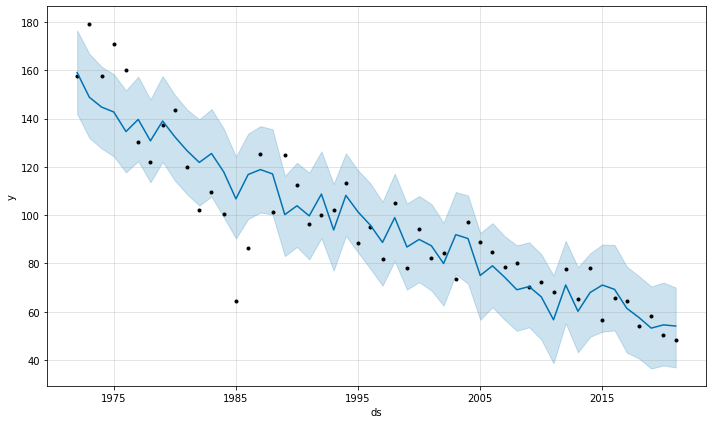

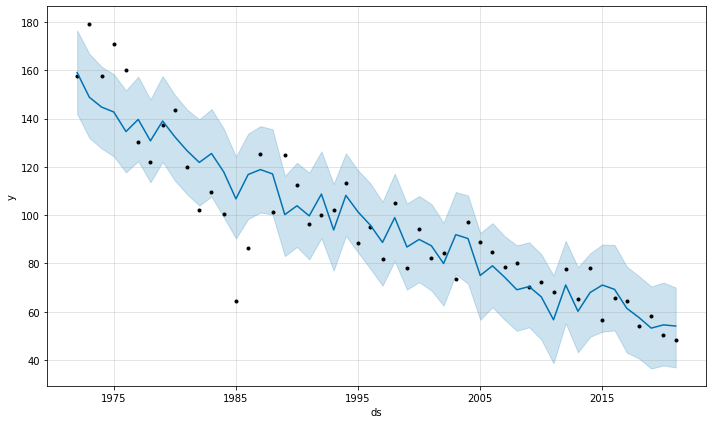

In [46]:
m.plot(past)

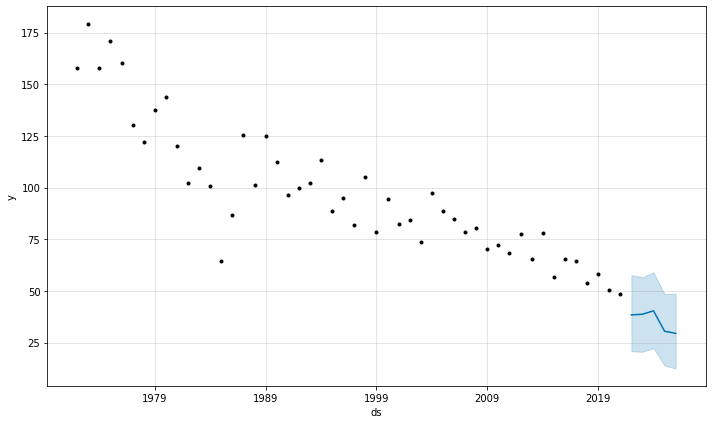

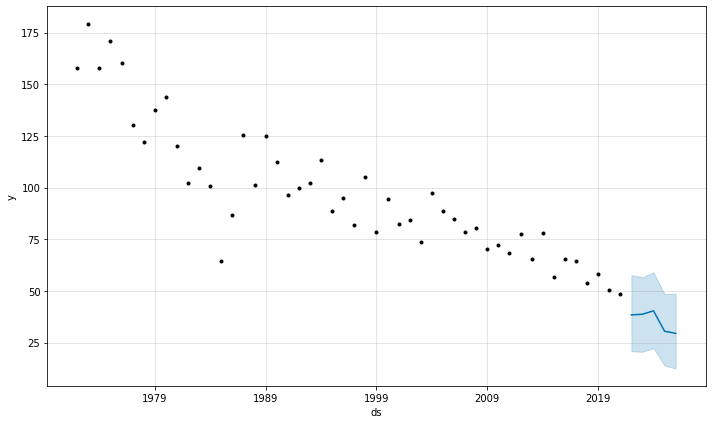

In [47]:
m.plot(forecast)

In [48]:
#Assessing Model Accuracy
#training model
predictions = past['yhat']
print('Traing RMSE: ', rmse(predictions, train['y']))
print('Average of Train Data: ', train['y'].mean())
print('Training RMSE/AVG: ', rmse(predictions, train['y'])/train['y'].mean())

print('')
print('*' * 30)
print('')

#Predictions
forecast['yhat']

Traing RMSE:  13.787032257008951
Average of Train Data:  97.21599440185177
Training RMSE/AVG:  0.14181855919735709

******************************



0    38.393532
1    38.717480
2    40.373027
3    30.486864
4    29.476196
Name: yhat, dtype: float64

In [49]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,vpdmin,vpdmin_lower,vpdmin_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,-40.712182,20.756024,57.685628,-40.712247,-40.712113,79.105714,79.105714,79.105714,-1.583240e-13,...,-2.823046e-14,-2.823046e-14,-2.823046e-14,79.105714,79.105714,79.105714,0.0,0.0,0.0,38.393532
1,2023-01-01,-42.939990,20.528623,56.665206,-42.940208,-42.939773,81.657470,81.657470,81.657470,-1.583240e-13,...,-2.823046e-14,-2.823046e-14,-2.823046e-14,81.657470,81.657470,81.657470,0.0,0.0,0.0,38.717480
2,2024-01-01,-45.167798,22.320516,58.977136,-45.168252,-45.167366,85.540825,85.540825,85.540825,-1.583240e-13,...,-2.823046e-14,-2.823046e-14,-2.823046e-14,85.540825,85.540825,85.540825,0.0,0.0,0.0,40.373027
3,2025-01-01,-47.401710,13.872687,48.400313,-47.402449,-47.401007,77.888575,77.888575,77.888575,-1.583240e-13,...,-2.823046e-14,-2.823046e-14,-2.823046e-14,77.888575,77.888575,77.888575,0.0,0.0,0.0,30.486864
4,2026-01-01,-49.629518,12.436066,48.664211,-49.630598,-49.628514,79.105714,79.105714,79.105714,-1.280995e-13,...,-9.410154e-15,-9.410154e-15,-9.410154e-15,79.105714,79.105714,79.105714,0.0,0.0,0.0,29.476196


# Sources

“Forecasting at Scale” Facebook. Accessed December 6, 2022. https://facebook.github.io/prophet/.


Nicolas (Nico) Fauchereau. “The impact of weather conditions on cycling counts in Auckland, New Zealand” Published September 12, 2018, Accessed December 6, 2022. https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb.



Jason Brownlee. “Time Series Forecasting With Prophet in Python” Machine Learning Mastery. Published August 26, 2020, Accessed December 6, 2022. https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/.
